# MS211 - Trabalho Computacional (Lista 6)

Carolina Laino Mustrangi (RA: 168473)

Pedro Sader Azevedo (RA: 243245)

Humberto Vinicius Queiroz Melo (RA: 172417)

## Parte I - Implementação do Modelo SEIR

In [1]:
using Plots

In [2]:
function simular_pandemia(r0::Float64, Tinc::Float64, Tinf::Float64,
                          S1::Float64, E1::Float64, I1::Float64, R1::Float64,
                          dias_total::Integer, dias_sem_quarentena::Integer = dias_total,
                          fator_quarentena::Float64 = 1/2)
    """
    Simula a evolução do quadro demográfico de uma pandemia usando o modelo SEIR, resolvendo
    as equações diferenciais envolvidas pelo Método do Ponto Médio.
    
    r0: número de reprodução
    Tinc: tempo de incubação
    Tinf: tempo de infecção
    
    S1: valor inicial de pessoas suscetíveis à doença
    E1: valor inicial de pessoas expostas à doença
    I1: valor inicial de pessoas infectadas com doença
    R1: valor inicial de pessoas removidas (curadas, falecidas, ou isoladas em UTI)
    
    dias_total: total de dias a serem simulados
    dias_sem_quarentena: dias decorridos antes da adoção de políticas públicas de isolamento social
    fator_quarentena: número, tipicamente entre 0 e 1, pelo qual é multiplicado o r0 ao adotar
                      políticas públicas de isolamento social
    """
    
    # gerar vetores
    S = zeros(dias_total)
    E = zeros(dias_total)
    I = zeros(dias_total)
    R = zeros(dias_total)
    
    # inicializar valores iniciais
    S[1], E[1], I[1], R[1] = S1, E1, I1, R1
    
    # definir F(y) = y'
    F(y)= [-(r0/Tinf)*y[1]*y[3];
        (r0/Tinf)*y[1]*y[3]- y[2]/Tinc; 
        y[2]/Tinc- y[3]/Tinf;
        y[3]/Tinf]
    
    # resolver a equação diferencial para os dias sem isolamento social
    h = 1
    for i = 2:dias_sem_quarentena
        y05 = [S[i-1];E[i-1];I[i-1];R[i-1]] + (h/2)*F([S[i-1];E[i-1];I[i-1];R[i-1]])
        S[i], E[i], I[i], R[i] = [S[i-1];E[i-1];I[i-1];R[i-1]] + h*F(y05) 
    end
    
    # resolver a equação diferencial para os dias com isolamento social 
    r0 = r0*fator_quarentena
    for i = (dias_sem_quarentena + 1):dias_total
        y05 = [S[i-1];E[i-1];I[i-1];R[i-1]] + (h/2)*F([S[i-1];E[i-1];I[i-1];R[i-1]])
        S[i], E[i], I[i], R[i] = [S[i-1];E[i-1];I[i-1];R[i-1]] + h*F(y05)  
    end
    
    # retornar quadro demográfico completo
    return S, E, I, R
end

simular_pandemia (generic function with 3 methods)

In [3]:
r0 = 2.5
Tinc = 5.2
Tinf = 2.9
S1 = 1 - 1e-6
E1 = 1e-6
I1 = 0.0
R1 = 0.0
dias_total = 498;

In [4]:
S, E, I, R = simular_pandemia(r0, Tinc, Tinf,
                              S1, E1, I1, R1,
                              dias_total);

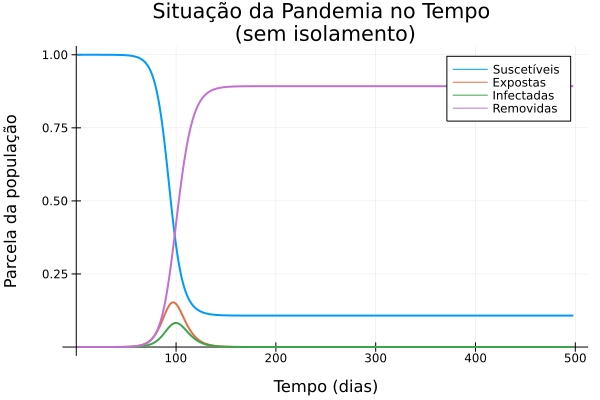

In [5]:
t = [1:1:dias_total;]
plot(t, S, w=2, label = "Suscetíveis")
plot!(t, E, w=2, label = "Expostas")
plot!(t, I, w=2, label = "Infectadas")
plot!(t, R, w=2, label = "Removidas")
grafico_sem_isolamento = plot!(title = "Situação da Pandemia no Tempo \n(sem isolamento)",
                               ylabel = "Parcela da população",
                               xlabel = "Tempo (dias)",
                               framestyle = :origin)

## Parte II - Respostas às Perguntas

In [6]:
# constantes úteis para responder às perguntas
const LEITOS_DISPONIVEIS_POR_HABITANTE = 27/100e3
const LEITOS_NECESSARIOS_POR_REMOVIDA = 0.03
const HABITANTES = 44.04e6
const LEITOS = LEITOS_DISPONIVEIS_POR_HABITANTE * HABITANTES;

### Questão 1

O número máximo de pessoas doentes no mesmo dia é o valor máximo do vetor $\mathcal{I}$. Para obter esse valor e seu índice com uma única iteração, utilizamos a função abaixo.

In [7]:
function maiorvalor(v)
    """ Função que retorna o maior valor de um vetor e seu indice """
    max = 0
    max_indice = 0
    for i in 1:length(v)
        if v[i] > max
            max = v[i]
            max_indice = i
        end
    end
    return max, max_indice
end

# exemplo
maiorvalor([1, 2, 3, 4, 999, 7, 8, 9])

(999, 5)

In [8]:
propocao_maxima_pessoas_doentes, _ = maiorvalor(I)

(0.08247171936415132, 100)

Como podemos ver acima, a maior proporção de pessoas doentes observadas em um único dia seria de aproximadamente 8,25% da população. Considerando que o estado de São Paulo possui 44,04 milhões de habitantes, essa proporção representaria 3632055 pessoas.

### Questão 2

Seriam necessários 100 dias para chegar no pico de doentes.

### Questão 3

a) Para calcular a proporção de pessoas que entram diariamente no grupo $\mathcal{R}$ de Removidas, vamos calcular o fluxo de $\mathcal{R}$ no tempo (ou seja, $\frac{d\mathcal{R}}{dt}$) a partir da diferença entre um termo e seu anterior.

In [9]:
dR = zeros(dias_total - 1)
for i in 1:dias_total - 1
    dR[i] = R[i + 1] - R[i]
end

In [10]:
dR

497-element Vector{Float64}:
 3.315649867374005e-8
 7.028253520565841e-8
 9.884575515540436e-8
 1.2396783632566257e-7
 1.486659009108171e-7
 1.748299696382825e-7
 2.0376571041399432e-7
 2.364987248964081e-7
 2.7394848500622744e-7
 3.170315508174757e-7
 3.6672704361747153e-7
 4.241227028343163e-7
 4.90451824866355e-7
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

b) Agora vamos usar o vetor calculado na questão anterior para avaliar a demanda diária de leitos no estado de São Paulo.

In [11]:
demanda_diaria_leitos = dR * HABITANTES * LEITOS_NECESSARIOS_POR_REMOVIDA;

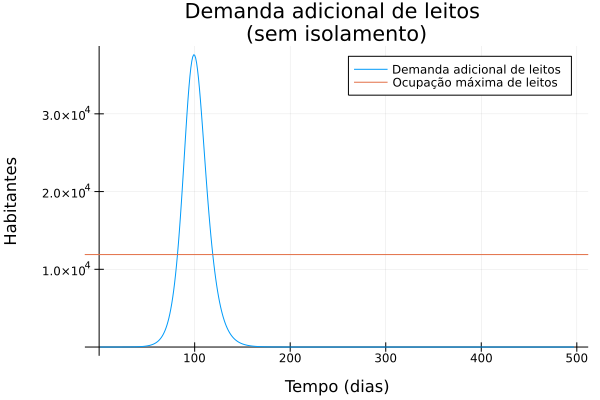

In [12]:
plot([1:1:dias_total - 1;],
     demanda_diaria_leitos,
     title = "Demanda adicional de leitos \n(sem isolamento)",
     label = "Demanda adicional de leitos",
     ylabel = "Habitantes",
     xlabel = "Tempo (dias)",
     framestyle = :origin)
hline!([LEITOS], label = "Ocupação máxima de leitos")

c) Para estimar a demanda acumulada de leitos, considerando que o tempo mediano de internação na UTI é de uma semana, somamos à demanda adicional diária de cada dia da simulação a demanda dos seis dias anteriores. 

In [13]:
demanda_acumulada_leitos = zeros(dias_total - 7)

for i in 7:dias_total - 1
    s = 0
    for j in 0:6
        s += demanda_diaria_leitos[i - j]
    end
    demanda_acumulada_leitos[i - 6] = s
end

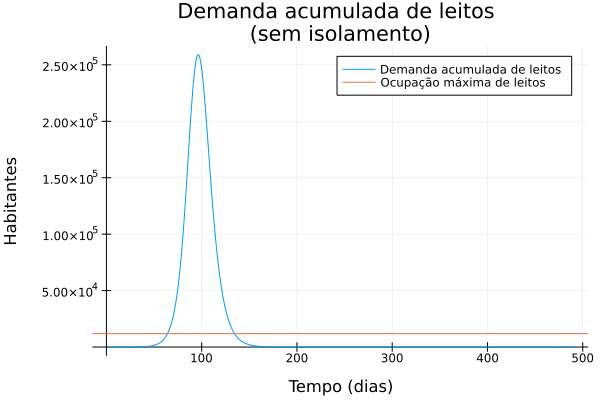

In [14]:
plot([1:1:(dias_total-7);],
     demanda_acumulada_leitos,
     title = "Demanda acumulada de leitos \n(sem isolamento)",
     label = "Demanda acumulada de leitos",
     ylabel = "Habitantes",
     xlabel = "Tempo (dias)",
     framestyle = :origin)
hline!([LEITOS], label = "Ocupação máxima de leitos")

d) O número de leitos necessários para atender a todos que precisarem de UTI é o valor máximo da curva acima. Como podemos ver abaixo, esse valor passa de 250 mil!

In [15]:
leitos_necessarios, dia_maior_demanda = maiorvalor(demanda_acumulada_leitos)
dia_maior_demanda += 7 # já que começamos do sétimo dia

@show(leitos_necessarios)
@show(dia_maior_demanda);

leitos_necessarios = 258956.5221262769
dia_maior_demanda = 103


In [16]:
disponibilidade_proporcional_leitos = (LEITOS/leitos_necessarios)
@show(disponibilidade_proporcional_leitos);

disponibilidade_proporcional_leitos = 0.04591813290650235


Isso significa que o estado de São Paulo não teria sequer 5% dos leitos necessários para lidar com a pandemia, caso não fossem adotadas políticas públicas de mitigação da transmissão da doença. Vamos elaborar mais sobre a eficácia dessas medidas na questão 6.

### Questão 5

A fim estimar o número de pessoas que ficarão sem acesso a UTIs, vamos somar a demanda diária adicional de leitos no intervalo em que a demanda acumulada está acima da ocupação máxima. Começamos descobrindo esse intervalo:

In [17]:
# primeira raiz: troca de sinal negativo para positivo
@show(demanda_acumulada_leitos[64] - LEITOS)
@show(demanda_acumulada_leitos[65] - LEITOS);

demanda_acumulada_leitos[64] - LEITOS = -182.06663478088376
demanda_acumulada_leitos[65] - LEITOS = 1590.6849452876268


In [18]:
# segunda raiz: troca de sinal positivo para negativo
@show(demanda_acumulada_leitos[134] - LEITOS)
@show(demanda_acumulada_leitos[135] - LEITOS);

demanda_acumulada_leitos[134] - LEITOS = 665.1197481606669
demanda_acumulada_leitos[135] - LEITOS = -663.634126119372


O primeiro índice do vetor `demanda_acumulada_leitos` representa o sétimo dia, nosso intervalo é `[64 + 7, 134 + 7]`. Assim, temos que o total de pessoas que ficariam sem UTI é:

In [19]:
total_pessoas_sem_leito = sum(demanda_diaria_leitos[64 + 7: 134 + 7])

1.1514123409504758e6

Observe, na célula abaixo, que esse número representa a esmagadora maioria das pessoas que precisarão de UTI durante a pandemia!

In [20]:
porcentagem_pessoas_sem_leito = (total_pessoas_sem_leito /
                                (LEITOS_NECESSARIOS_POR_REMOVIDA * HABITANTES)) * 100

print("Parcela da população que precisaria de UTI mas ficaria sem: ~",
      round(porcentagem_pessoas_sem_leito, digits = 2), "%")

Parcela da população que precisaria de UTI mas ficaria sem: ~87.15%

### Questão 6

A simulação acima prevê uma verdadeira calamidade para o estado de São Paulo, caso não fossem adotadas medidas para conter a propagação da COVID-19. Com o propósito de argumentar a favor de políticas de saúde pública (isolamento social, uso de máscaras em espaços públicos, etc) como prevenções de tal calamidade, vamos simular a pandemia novamente usando um número de reprodução mais baixo após os primeiros dois meses e meio. A ideia é representar a adoção de políticas de saúde pública com essa diminuição no número de reprodução.

In [21]:
dias_sem_quarentena = 85 # dois meses e meio
fator_quarentena = 1/2;

In [22]:
# "p" de "políticas de saúde pública"
Sp, Ep, Ip, Rp = simular_pandemia(r0, Tinc, Tinf,
                                  S1, E1, I1, R1,
                                  dias_total, dias_sem_quarentena,
                                  fator_quarentena);

In [26]:
t = [1:1:dias_total;]
plot(t, Sp, w=2, label = "Suscetíveis")
plot!(t, Ep, w=2, label = "Expostas")
plot!(t, Ip, w=2, label = "Infectadas")
plot!(t, Rp, w=2, label = "Removidas")
grafico_com_isolamento = plot!(title = "Situação da Pandemia no Tempo \n(com isolamento)",
                               ylabel = "Parcela da população",
                               xlabel = "Tempo (dias)",
                               framestyle = :origin);

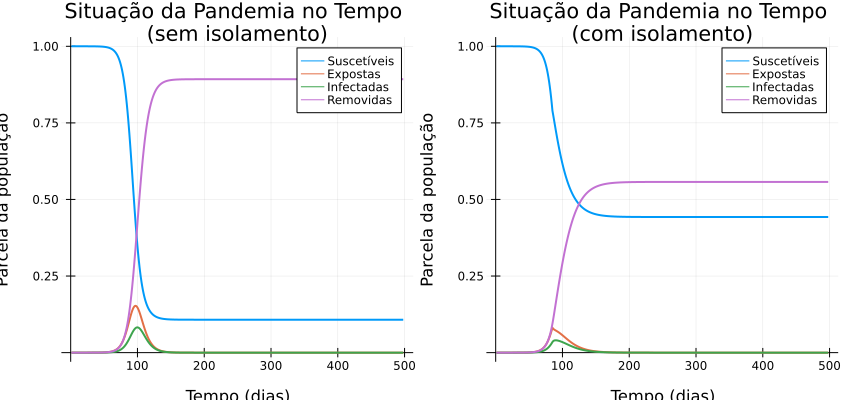

In [27]:
plot(grafico_sem_isolamento, grafico_com_isolamento, layout = (1, 2), size = (850,400))

In [34]:
ultimo = length(S)

# mais pessoas continuarão suscetíveis se adotarmos medidas de saúde pública (o que é bom)
@show(S[ultimo])
@show(Sp[ultimo])

# menos pessoas serão removidas se adotarmos medidas de saúde pública (o que também é bom)
@show(R[ultimo])
@show(Rp[ultimo]);

S[ultimo] = 0.10750283884619916
Sp[ultimo] = 0.4427304761950461
R[ultimo] = 0.8924971611538011
Rp[ultimo] = 0.5572695238021963


Ao comparar as simulações acima, fica evidente a importância de políticas de saúde pública para evitar que os hospitais de São Paulo enfrentasse uma sobrecarga catastrófica (um cenário pior do que o que de fato ocorreu ao longo da pandemia do COVID-19).

Note que o pico de infecções é mais baixo no cenário em que são adotadas medidas de conteção, assim diminuindo o excesso de demanda por atendimento hospitalar. Além disso, uma parcela menor da população vai para o grupo $\mathcal{R}$ e uma parcela maior permanece no grupo $\mathcal{S}$ nesse caso, indicando que a nem toda a população contrai a doença durante o intervalo simulado. Logo, podemos concluir que ao implementar as medidas de restrição, como menos pessoas foram removidas, menos pessoas foram expostas e infectadas, então as restrições foram positivas para a não exposição e a não infecção de pessoas.

Em vista disso, diríamos ao governador do estado no início de pandemia que as medidas de restrição de circulação são necessárias para impedir o cenário em que não há leitos suficientes para a quantidade de pessoas que os necessitariam.